In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import vmo.generate as vge
import pretty_midi
import numpy as np
import librosa
import matplotlib.pyplot as plt
import vmo
import sklearn.preprocessing as pre
import music21 
from vmo.VMO.utility.distances.tonnetz import distance as tonnetz
import vmo.plot as vplot
import vmo.analysis.hmm as hmm
import copy
import string
import pickle
import vmo.analysis as van
import vmo.generate as vge
import IPython.display
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

%matplotlib inline

pil not loaded - hopefully running in max


In [3]:
midi_path = "/Users/eseetao/Documents/CREL/Magenta/attention_rnn/Summer/Summer2.1.mid"
#midi_path = "/Users/eseetao/Documents/CREL/Magenta/lookback_rnn/SummerLookback.mid"
#midi_path = "/Users/eseetao/Documents/CREL/Magenta/lookback_rnn/SummerBasic.mid"

midi_data = pretty_midi.PrettyMIDI(midi_path)
piece = midi_path.split('/')[-1][:-4]
fs = midi_data.resolution

In [4]:
piano_matrix = midi_data.get_piano_roll(fs=fs)
midi_chroma = midi_data.get_chroma(fs=fs)

beat_num = 4
beats_time = midi_data.get_beats()
bar_time = [beats_time[i] for i in range(0,len(beats_time),beat_num)]
bar_time = np.append(bar_time, midi_data.get_end_time())
beats = np.floor(beats_time*fs).astype(int)
bars = [beats[i] for i in range(0,len(beats),beat_num)]

bar_chroma = librosa.util.sync(pre.minmax_scale(midi_chroma, axis=1), bars, aggregate=np.max)+np.finfo(float).eps
bar_chroma = bar_chroma.T[2:,:].T

In [5]:
# Build target oracle
r = (0, 1.01, 0.005)
bar_threshold = vmo.find_threshold(bar_chroma.T, r=r, dim=12, dfunc='other', dfunc_handle=tonnetz)

## Information Rate

/Users/eseetao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


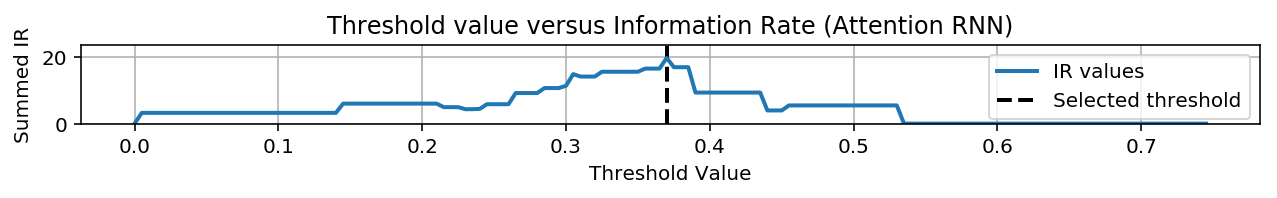

In [6]:
ideal_bar_t = bar_threshold[0][1]
oracle_t = vmo.build_oracle(bar_chroma.T, flag='a', threshold=ideal_bar_t, dim=12, dfunc='other', dfunc_handle=tonnetz)

x_t = [i[1] for i in bar_threshold[1]]
y_t = [i[0] for i in bar_threshold[1]]

plt.figure(figsize=(9,1.5))
plt.plot(x_t[:150], y_t[:150], linewidth = 2)
plt.vlines(ideal_bar_t, 0.0, 1.2*np.max(y_t), colors='k',linestyle = 'dashed', linewidth = 2)
plt.grid('on')
plt.legend(['IR values', 'Selected threshold'], loc=1)
plt.title('Threshold value versus Information Rate (Attention RNN)')
plt.xlabel('Threshold Value')
plt.ylabel('Summed IR')
plt.ylim([0,1.2*np.max(y_t)])
plt.tight_layout()
plt.savefig('IRAttention.png')

## Pattern Findings

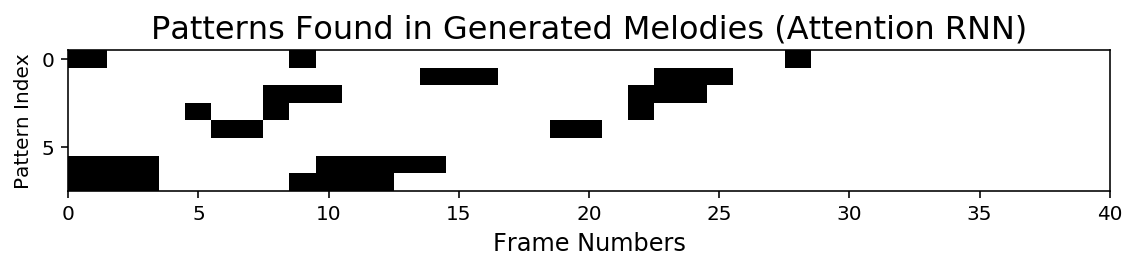

In [7]:
min_len = 1
pattern = van.find_repeated_patterns(oracle_t, lower = min_len)
pattern_mat = np.zeros((len(pattern), oracle_t.n_states-1))
for i,p in enumerate(pattern):
    length = p[1]
    for s in p[0]:
        pattern_mat[i][s-length:s-1] = 1

plt.figure(figsize = (8,2))
plt.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
# plt.title('Patterns Found with VMO',fontsize=12)
plt.title('Patterns Found in Generated Melodies (Attention RNN)',fontsize=16)

# plt.yticks(np.arange(pattern_mat.shape[0]))
plt.ylabel('Pattern Index')
plt.xlabel('Frame Numbers',fontsize=12)
plt.xlim(0,40)
plt.tight_layout()
plt.savefig('patternAttention.png')

## MIDI Chroma

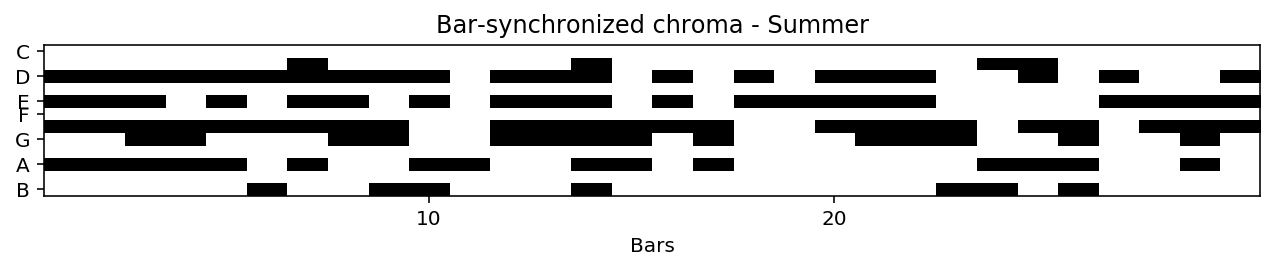

In [8]:
piano_matrix = midi_data.get_piano_roll(fs=fs)
midi_chroma = midi_data.get_chroma(fs=fs)

beat_num = 4
beats_time = midi_data.get_beats()
bar_time = [beats_time[i] for i in range(0,len(beats_time),beat_num)]
bar_time = np.append(bar_time, midi_data.get_end_time())
beats = np.floor(beats_time*fs).astype(int)
bars = [beats[i] for i in range(0,len(beats),beat_num)]

bar_chroma = librosa.util.sync(pre.minmax_scale(midi_chroma, axis=1), bars, aggregate=np.max)+np.finfo(float).eps
bar_chroma = bar_chroma.T[2:,:].T

plt.figure(figsize=(9, 2))
plt.imshow(bar_chroma, aspect='auto', interpolation='nearest', cmap='Greys')
plt.title('Bar-synchronized chroma - Summer')
plt.yticks([0,2,4,5,7,9,11], ['C','D','E','F','G','A','B'])
plt.xticks(range(9,20,10),range(10,90,10))
plt.xlabel('Bars')
plt.tight_layout()
plt.savefig('midi_chroma.pdf')

## Clusters

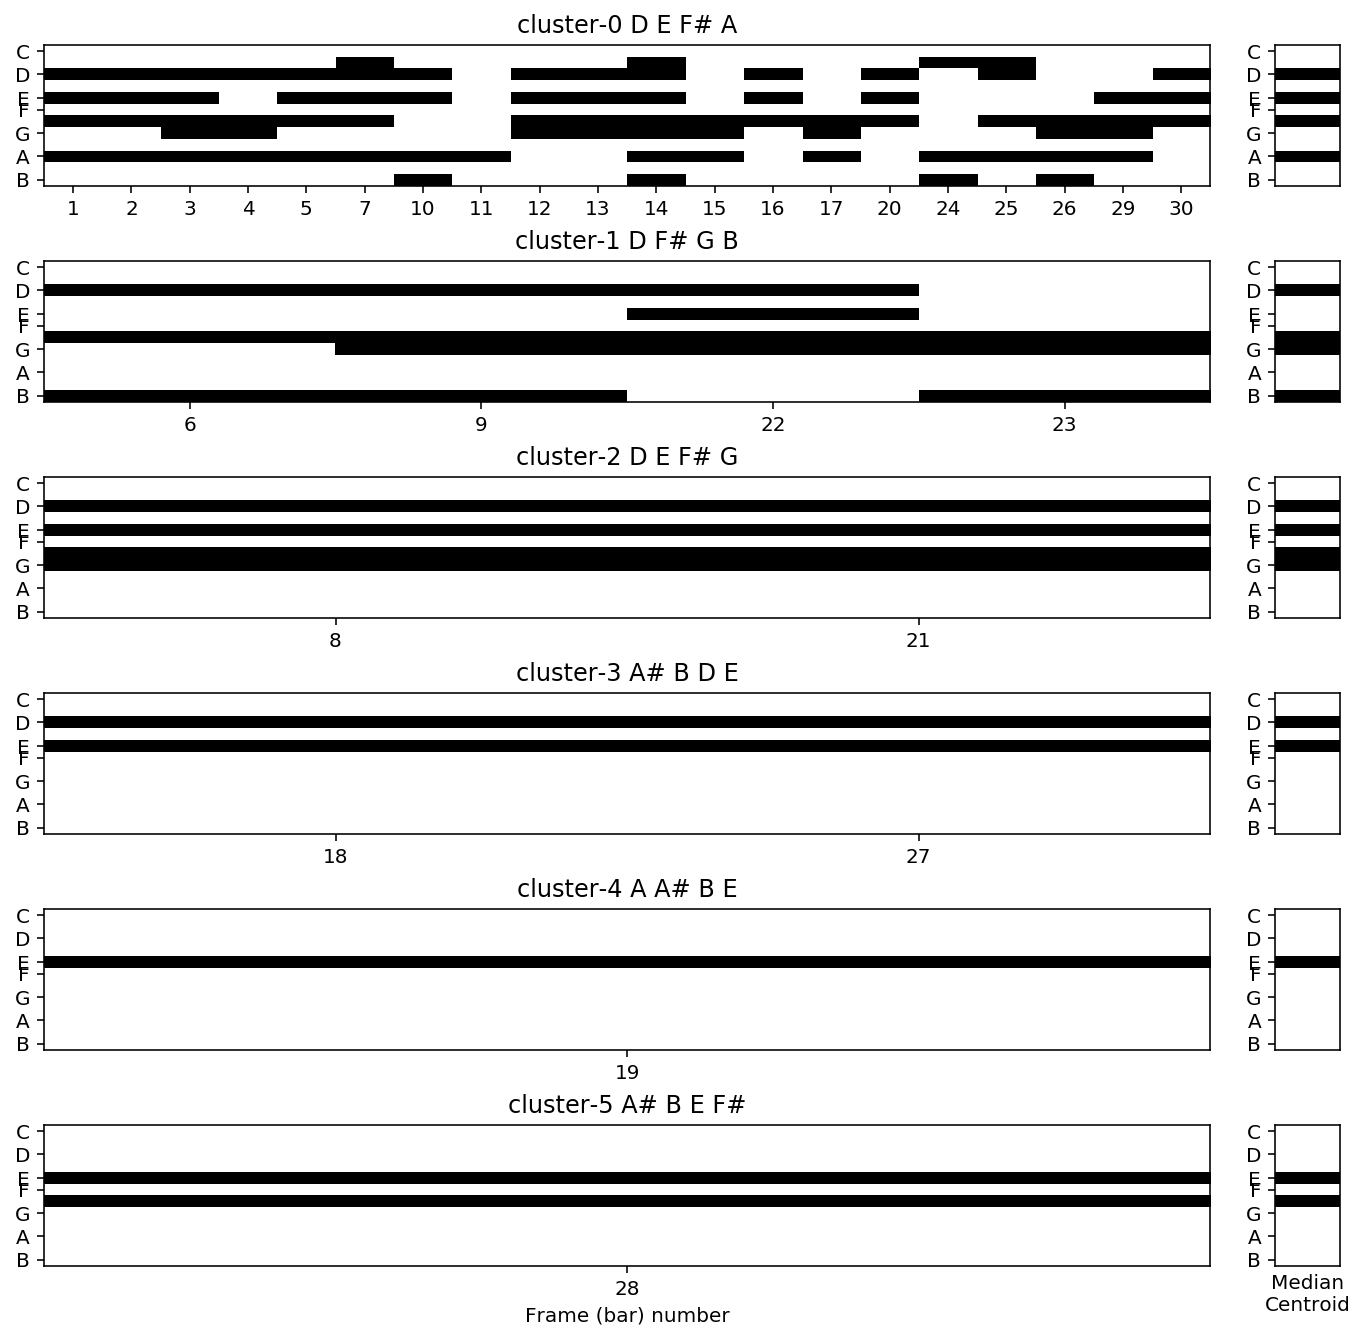

In [9]:
chord_list = []

fig = plt.figure(figsize=(9, 1.5*len(oracle_t.latent)))

for i,c in enumerate(oracle_t.latent):
    cluster_mat = bar_chroma.T[np.array(c)-1]
    ax1 = fig.add_axes([0., float(len(oracle_t.latent)-i-1)/len(oracle_t.latent), 0.9, (.65)/len(oracle_t.latent)])
    ax2 = fig.add_axes([0.95, float(len(oracle_t.latent)-i-1)/len(oracle_t.latent), 0.05, (.65)/len(oracle_t.latent)])
    cluster_mean = np.median(oracle_t.f_array.data[np.array(c),:].T, axis=1)
    
    chroma = vplot.plot_chroma_as_chord(cluster_mean, n_pitch=4)
    chord_list.append(chroma)
    ax1.imshow(cluster_mat.T, aspect='auto', interpolation='nearest', cmap='Greys')
    ax1.set_yticks([0,2,4,5,7,9,11])
    ax1.set_yticklabels(['C','D','E','F','G','A','B'])
    ax1.set_xticks(range(len(c)))
    ax1.set_xticklabels(c)
    if i == len(oracle_t.latent)-1:
        ax1.set_xlabel('Frame (bar) number')
        ax2.set_xlabel('Median\nCentroid')
    ax1.set_title("cluster-"+str(i)+" "+str(" ".join(chroma.pitchNames)))
    ax2.imshow(cluster_mean.reshape((1,-1)).T, aspect='auto', interpolation='nearest', cmap='Greys')
    ax2.set_yticks([0,2,4,5,7,9,11])
    ax2.set_yticklabels(['C','D','E','F','G','A','B'])    
    ax2.set_xticks([])
fig.savefig('cluster.pdf')